In [1]:
import pandas as pd
from pathlib import Path
import torch
import json
import os
import seaborn as sns
import time
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

/homes/dlupo/.local/lib/python3.9/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


In [2]:
# Load data path
PATH_FOLDER_COPY_NUMBER = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/CopyNumber"
PATH_CASE_ID_STRUCTURE = "/homes/dlupo/Progetto_BioInformatics/AI_for_Bioinformatics_Project/Preprocessing/Final/case_id_and_structure.json"
PATH_FOLDER_GENE = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/GeneExpression"
PATH_GENE_ID_PROTEIN_CODING = "/homes/dlupo/Progetto_BioInformatics/AI_for_Bioinformatics_Project/Preprocessing/Final/gene_id_protein_coding.json"

In [3]:
with open(PATH_CASE_ID_STRUCTURE, 'r') as file:
	file_parsed = json.load(file)

copy_number_folder_list = []
os_list = []
for key in file_parsed.keys():
	copy_number_folder_list.append(file_parsed[key]["files"]["copy_number"])
	os_list.append(file_parsed[key]['os'])

def remove_version(x):
	if '.' in x:
		return x.split('.')[0]
	return x

gene_id_list = []
with open(PATH_GENE_ID_PROTEIN_CODING) as json_file:
	gene_id_list = json.load(json_file)

# Convert gene_id_list into a set data structure to speed up the lookup
gene_id_set = set(gene_id_list)

list_df_CNV = []
for root, dirs, files in os.walk(PATH_FOLDER_COPY_NUMBER):
	for dir in dirs:
		for root, dirs, files in os.walk(PATH_FOLDER_COPY_NUMBER + "/" + dir):
			for file in files:
				if file in copy_number_folder_list:
					parsed_file = pd.read_csv(PATH_FOLDER_COPY_NUMBER + "/" + dir + "/" + file, sep='\t')
					attributes = ['chromosome','start','end','min_copy_number','max_copy_number','gene_name']
					parsed_file.drop(columns=attributes, inplace=True)
					parsed_file['gene_id'] = parsed_file['gene_id'].apply(remove_version)
					parsed_file = parsed_file[parsed_file['gene_id'].isin(gene_id_set)].fillna(0)
					list_df_CNV.append(parsed_file)


In [8]:
scaler = StandardScaler()
list_df_CNV_scaling = []
for i in range(len(list_df_CNV)):
    df = list_df_CNV[i]
    X_scaled = scaler.fit_transform(df['copy_number'].values.reshape(-1,1))
    df = df.drop(columns='copy_number')
    df['copy_number'] = X_scaled.flatten()
    list_df_CNV_scaling.append(df)

NameError: name 'StandardScaler' is not defined

In [4]:
# Creiamo un set per ogni dataframe e verifichiamo se sono tutti uguali
set_values = {frozenset(df['gene_id'].unique()) for df in list_df_CNV}

if len(set_values) == 1:
	print("All dataframes have same values for gene_id column")
else:
	print("dataframes have different value for gene_id column")

All dataframes have same values for gene_id column


In [ ]:
# Concatenare tutti i dataframe
df_concatenato = pd.concat(list_df_CNV)

# Calcolare la varianza per ogni gene_id
varianze = df_concatenato.groupby('gene_id')['copy_number'].var()

# Soglia per selezionare le righe più variabili (esempio: selezioniamo sopra la mediana)
soglia = varianze.median()
# gene_significativi = varianze[varianze > soglia].index

In [7]:
df_var = pd.DataFrame(varianze.values, columns=['variance'])
df_var_sorted = pd.DataFrame(df_var.sort_values(by=['variance'],ascending=False).values, columns=['variance'])

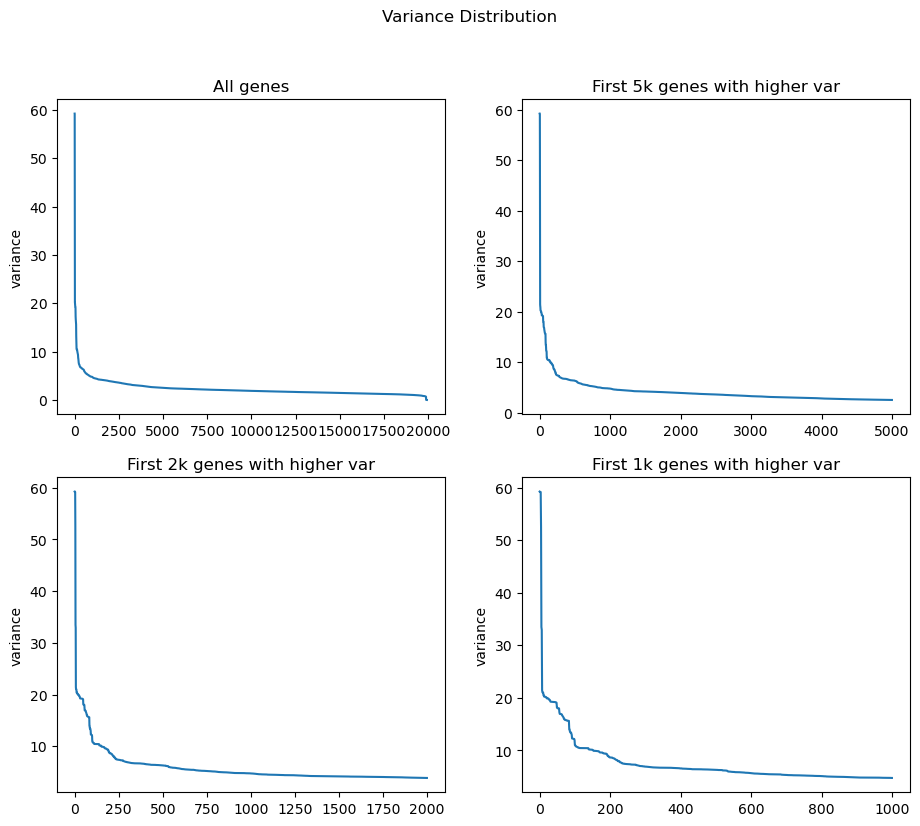

In [8]:
df_var1 = df_var_sorted
df_var2 = df_var_sorted[df_var_sorted.index < 5000]
df_var3 = df_var_sorted[df_var_sorted.index < 2000]
df_var4 = df_var_sorted[df_var_sorted.index < 1000]

figure, axes = plt.subplots(2, 2, sharex=False, figsize=(11,9))
sns.lineplot(ax=axes[0,0], x=df_var1.index, y=df_var1['variance'])
sns.lineplot(ax=axes[0,1], x=df_var2.index, y=df_var2['variance'])
sns.lineplot(ax=axes[1,0], x=df_var3.index, y=df_var3['variance'])
sns.lineplot(ax=axes[1,1], x=df_var4.index, y=df_var4['variance'])
figure.suptitle('Variance Distribution')
axes[0,0].set_title('All genes')
axes[0,1].set_title('First 5k genes with higher var')
axes[1,0].set_title('First 2k genes with higher var')
axes[1,1].set_title('First 1k genes with higher var')
plt.show()


In [ ]:
df_concatenato = pd.concat(datastructure_Gene['values'].values)

# Calcolare la varianza per ogni gene_id
varianze = df_concatenato.groupby('gene_id')['tpm_unstranded'].var()
top_n = 2000  # numero di geni che si vuole mantenere
gene_significativi = varianze.nlargest(top_n).index

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

list_df_CNV_filtered = []
for i in range(len(list_df_CNV)):
	df = list_df_CNV[i][list_df_CNV[i]['gene_id'].isin(gene_significativi)]
	X_scaled = scaler.fit_transform(df['copy_number'].values.reshape(-1,1))
	df = df.drop(columns='copy_number')
	df['copy_number'] = X_scaled.flatten()
	df = df.drop_duplicates(subset=['gene_id'])
	list_df_CNV_filtered.append(df)


NameError: name 'varianze' is not defined

In [7]:
        file_to_case_id = dict((file_parsed[k]['files']['gene'], k) for k in file_parsed.keys())
        datastructure_Gene = pd.DataFrame(columns=['values'])
        index = 0
        for root, dirs, files in os.walk(PATH_FOLDER_GENE):
            for dir in dirs:
                for root, dirs, files in os.walk(PATH_FOLDER_GENE + "/" + dir):
                    for file in files:
                        if file in file_to_case_id.keys():
                            parsed_file = pd.read_csv(PATH_FOLDER_GENE + "/" + dir + "/" + file,
                                                    sep='\t', header=0, skiprows=lambda x: x in [0, 2, 3, 4, 5])
                            parsed_file = parsed_file[['gene_id','tpm_unstranded']]

                            # Now specify columns type.
                            convert_dict = dict([(k, float) for k in ['tpm_unstranded']])
                            convert_dict['gene_id'] = str
                            parsed_file = parsed_file.astype(convert_dict)

                            parsed_file['gene_id'] = parsed_file['gene_id'].apply(remove_version)
                            parsed_file = parsed_file[parsed_file['gene_id'].isin(gene_id_set)]
                            datastructure_Gene.loc[index] = [
                                parsed_file
                            ]
                            index += 1


In [ ]:
		df_concatenato = pd.concat(datastructure_Gene['values'].values)

		# Calcolare la varianza per ogni gene_id
		varianze = df_concatenato.groupby('gene_id')['tpm_unstranded'].var()

		top_n = 200  # numero di geni che si vuole mantenere
		gene_significativi = varianze.nlargest(top_n).index 

		# Apply log.
		for i in range(datastructure_Gene.shape[0]):
			datastructure_Gene['values'].loc[i][['tpm_unstranded']] = datastructure_Gene['values'].loc[i][['tpm_unstranded']].applymap(lambda x: np.log10(x + 0.01))
		
		# Make value in a [0, 1] range.
		for r in range(datastructure_Gene.shape[0]):
			for c in ['tpm_unstranded']:
				datastructure_Gene['values'].loc[r][c] =    (datastructure_Gene['values'].loc[r][c] - datastructure_Gene['values'].loc[r][c].min()) / \
															(datastructure_Gene['values'].loc[r][c].max() - datastructure_Gene['values'].loc[r][c].min())
		list_df_Gene_filtered = []
		for case_index in range(datastructure_Gene.shape[0]):
			df = datastructure_Gene['values'].loc[case_index][datastructure_Gene['values'].loc[case_index]['gene_id'].isin(gene_significativi)]
			df = df.drop_duplicates(subset=['gene_id'])
			list_df_Gene_filtered.append(df)

In [90]:
list_df_CNV_filtered_gene = []
for case_index in range(len(list_df_CNV)):
    df = list_df_CNV[case_index][list_df_CNV[case_index]['gene_id'].isin(list_df_Gene_filtered[case_index]['gene_id'])].drop_duplicates(subset=['gene_id'])
    df = df.drop_duplicates(subset=['gene_id'])
    df = pd.DataFrame(df.sort_values('gene_id').values, columns=['gene_id','copy_number'])
    list_df_CNV_filtered_gene.append(df)
	# df = pd.DataFrame(list_df_Gene_filtered[case_index].sort_values('gene_id').values, columns=['gene_id','tpm_unstranded'])
	# list_df_Gene_filtered[case_index] = df

In [96]:
list_df_CNV_filtered_gene[0]

,gene_id,copy_number
0,ENSG00000001626,2.0
1,ENSG00000002586,2.0
2,ENSG00000002726,2.0
3,ENSG00000004848,2.0
4,ENSG00000006128,2.0
...,...,...
495,ENSG00000274512,2.0
496,ENSG00000274588,2.0
497,ENSG00000275410,2.0
498,ENSG00000283992,2.0


In [97]:
list_df_Gene_filtered[0]

,gene_id,tpm_unstranded
15,ENSG00000001626,0.826602
23,ENSG00000002586,0.858035
26,ENSG00000002726,0.617853
65,ENSG00000004848,0.000000
127,ENSG00000006128,0.000000
...,...,...
52865,ENSG00000274512,0.803644
52901,ENSG00000274588,0.000000
53316,ENSG00000275410,0.000000
57299,ENSG00000283992,0.652445


In [100]:
from sklearn.metrics import pairwise_distances
THRESHOLD = 0.02
list_of_Data = []
for case_index in range(len(list_df_Gene_filtered)):
	edges = []
	in_1 = [[v] for v in list(list_df_Gene_filtered[case_index]['tpm_unstranded'])]

	dist_a = pairwise_distances(in_1, metric="euclidean")

	d_mask = np.zeros(dist_a.shape, dtype=bool)
	np.fill_diagonal(d_mask, 1)

	# Force the diagonal to be equal to Threshold, so it will not be considered, so no self loops.
	dist_a[d_mask] = THRESHOLD

	row, cols = np.where(dist_a < THRESHOLD)
	edges.append(list(row))
	edges.append(list(cols))

	edge_index = torch.tensor(edges, dtype=torch.long)
	x = torch.tensor(list(list_df_CNV_filtered_gene[case_index]['copy_number']), dtype=torch.float)
	y = torch.tensor(os_list[case_index])
	list_of_Data.append(Data(x=x, edge_index=edge_index, y=y))


In [101]:
import numpy as np
list_edges = [list_of_Data[i].num_edges for i in range(len(list_of_Data))]
np.mean(list_edges)/2

12182.907079646018